## Testing GWA on stochastic block model networks

Through a bunch of testing on asymmetric networks, it appears that GWA works best on networks that have a block-like structure. In this notebook, we show how GWA can be used to simplify an asymmetric, weighted, stochastic block model (SBM) network. 

In [1]:
# Import packages
import scipy as sp
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import ot
import time
from ot.bregman import sinkhorn
from ot.utils import dist
from ot.optim import cg
import gromovWassersteinAveraging as gwa
from sklearn import manifold
from sklearn.cluster import KMeans
import pandas as pd

import os 
from os.path import dirname, join as pjoin
import scipy.io as sio

# For easy editing
%load_ext autoreload
%autoreload 2

In [2]:
simpleNets = sio.loadmat("simpleNets.mat")
simpleNets_prob = sio.loadmat("simpleNets_prob.mat")


simpleNets = simpleNets['simpleNets']
simpleNets_prob = simpleNets_prob['simpleNets_prob']

simpleNets = simpleNets[0]
simpleNets_prob = simpleNets_prob[0]

Now we load an SBM and plot it.

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


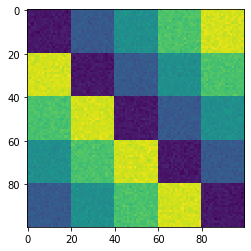

In [3]:
# 100 x 100 SBM network
A = simpleNets[12]
pA = simpleNets_prob[12]
pA = np.squeeze(pA)

fig = plt.figure()
plt.imshow(A)


B = np.zeros((5,5))
pB = ot.unif(5)
print(B)


Some info from the generation procedure: the blocks in A correspond to numbers 0, 25, 50, 75, 100, sampled with a fixed variance of 5. Here is what A looks like:

In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pd.DataFrame(A))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-1.194719,0.980236,-2.353751,1.049869,-2.392508,-2.528207,-2.470196,1.423031,-1.926790,-1.200988,-1.501886,-1.804977,1.731871,2.452618,-1.116337,2.224479,2.915848,0.984729,-4.261253,4.666699,27.176090,26.972799,24.769782,28.845315,29.360022,28.190992,20.336883,29.025420,25.146649,27.390377,27.836460,22.092976,24.571344,27.210092,21.919149,25.378318,26.883558,24.122401,26.398317,26.472621,50.266312,48.727230,50.276017,44.093859,51.926493,51.214549,47.572344,51.115239,51.097369,53.996231,48.511822,44.889882,47.314858,47.860712,50.048625,49.721651,48.855651,46.664987,49.257098,48.048809,78.289484,71.045006,78.109680,78.823837,77.313073,75.875108,73.333832,77.748623,73.021681,78.425083,78.651730,73.443702,73.848299,69.328092,76.582969,74.131881,70.941729,75.547960,76.141480,76.211249,100.830100,104.000398,100.415778,97.107488,99.697853,101.729205,99.634063,95.338381,102.306325,99.433761,104.273358,100.430577,101.180027,101.729935,102.159367,99.450190,99.778711,98.143446,97.180068,98.720855
1,-1.791712,0.675481,0.812775,-1.533176,-0.867149,2.150809,0.110656,-0.594850,-2.239659,0.608620,-1.868046,2.363707,-0.098098,-1.233680,-0.976196,-0.264471,2.603926,-1.443113,-6.459386,-0.747390,25.112116,24.326149,21.360930,25.176303,23.750259,27.930047,25.777778,25.551639,27.209293,22.365506,25.191271,22.872344,27.153724,26.032183,27.848059,24.072867,27.188997,26.490442,26.638078,22.203403,53.992813,47.143103,52.184102,50.078612,54.230729,52.070500,54.101866,51.591699,49.912133,45.562042,49.637536,48.750475,55.412768,48.878252,47.241755,50.898214,48.235848,53.528102,51.541945,48.843242,76.151472,75.203287,73.569266,76.434201,78.253459,73.434827,79.187689,76.709814,71.000380,74.306006,74.366122,76.776634,78.665630,71.162123,76.766431,76.760958,73.285300,75.272063,76.235329,74.705428,99.199259,101.152519,101.162121,100.984902,101.026047,101.668476,97.496111,101.811116,97.825378,96.697650,100.613124,99.074930,99.074513,100.487018,103.097459,103.085616,97.615850,99.770848,96.953815,99.578601
2,3.409111,-0.305923,3.131767,-0.270627,-2.014461,0.068288,-1.400183,0.554160,-1.849019,-2.125229,-0.067481,0.094987,3.526755,-2.178119,1.625023,2.851364,-3.595601,0.181709,0.618544,-0.846775,25.686087,26.892031,23.779959,23.713339,25.833233,27.019386,21.441420,27.850533,26.385881,28.418779,25.486614,23.572705,22.956885,27.702663,24.130569,21.317046,22.678196,26.183766,24.145197,21.680622,50.176933,51.519917,49.041431,51.191755,51.663348,55.556463,49.168555,51.039129,46.964528,47.857479,52.164486,54.875896,51.658312,48.786571,50.803921,52.121408,46.573660,47.979350,49.080748,52.082145,74.824577,75.363274,76.647830,74.313892,73.140436,77.416191,76.660731,75.641442,73.604381,76.083578,74.335774,73.089787,75.014141,78.080615,72.667678,76.600771,76.418826,77.632741,76.491392,76.765831,98.809076,103.579856,99.161725,103.073242,98.203597,100.980593,101.682886,102.914837,97.154308,103.177146,97.392490,101.577567,98.253907,99.220348,101.217260,98.124143,102.793760,97.634616,102.110209,99.747981
3,0.372415,-0.568530,-1.575211,-4.790488,-0.188106,-1.127087,1.293376,-3.577663,-1.424852,-0.908575,-0.485706,-4.939496,0.312670,4.254125,-3.263870,-0.087371,-0.422550,1.634720,-2.081085,2.964780,27.457504,27.841107,22.012369,23.914926,23.259244,25.218436,30.374071,26.962575,20.150428,27.635340,24.990175,25.202218,27.049499,29.211873,22.682429,24.857015,23.897404,21.159315,21.740260,21.702689,50.545443,47.771312,52.924714,50.927837,51.196957,48.630399,50.013704,50.343402,47.190201,50.119938,49.724753,48.259155,48.004472,49.028051,50.599960,47.422310,46.973924,49.638026,48.617376,49.264951,79.785016,77.562139,73.821084,76.143835,74.604958,77.200666,77.196220,76.092945,73.154062,74.696784,72.

B is a "zero network". Let's see what we get when we average them, but without allowing expansion. In other words, we are looking for the best 5 x 5 representation of A (we know that this "ground truth" simplified representation exists).

In [5]:
CList = [B,A]
pList = [pB,pA]


avg, Deltas, Frechet_Loss = gwa.network_karcher_mean_armijo_sched_compress(B,pB,CList,pList,budget=5,exploreIter = 20, maxIter = 30)

//anaconda3/lib/python3.7/site-packages/ot/optim.py:255: RuntimeWarning: invalid value encountered in double_scalars
  relative_delta_fval = abs_delta_fval / abs(f_val)


Iter Frechet_Loss
0 1761753.4226549019
current size  (5, 5)
1 469396.07767014916  full gradient step
current size  (5, 5)
2 220802.0410062892  full gradient step
current size  (5, 5)
3 220802.04100628913  full gradient step
current size  (5, 5)
4 220802.0410062892  full gradient step
current size  (5, 5)
5 220802.0410062892  full gradient step
current size  (5, 5)
6 220802.0410062892  full gradient step
current size  (5, 5)
7 220802.0410062892  full gradient step
current size  (5, 5)
8 220802.0410062892  full gradient step
current size  (5, 5)
9 220802.04100628913  full gradient step
current size  (5, 5)
10 220802.0410062892  full gradient step
current size  (5, 5)
11 220802.0410062892  full gradient step
current size  (5, 5)
12 220802.0410062892  full gradient step
current size  (5, 5)
13 220802.0410062892  full gradient step
current size  (5, 5)
14 220802.0410062892  full gradient step
current size  (5, 5)
15 220802.04100628913  full gradient step
current size  (5, 5)
16 220802.04100

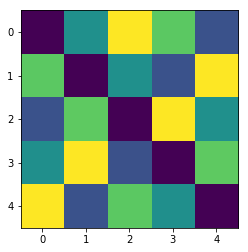

In [24]:
fig = plt.figure()
plt.imshow(avg)

We can 'eyeball' a permutation that makes the first row of the average looke like the first row of $A$. This is the permutation represented by the matrix:

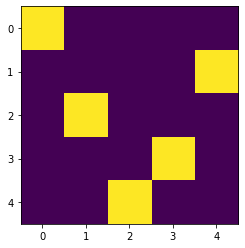

In [7]:
Perm = np.array([[1,0,0,0,0],[0,0,0,0,1],[0,1,0,0,0],[0,0,0,1,0],[0,0,1,0,0]])

plt.imshow(Perm);

Act on `avg` by this permutation matrix. 

In [8]:
avg2 = np.matmul(Perm,np.matmul(avg,np.transpose(Perm)))

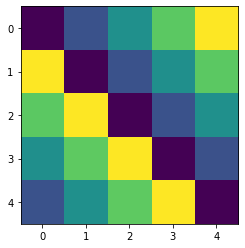

In [9]:
fig = plt.figure()
plt.imshow(avg2)

In [18]:
display(pd.DataFrame(avg2))

,0,1,2,3,4
0,0.047868,12.498209,24.983600,37.400937,49.979320
1,49.952022,-0.040458,12.579908,24.955653,37.481814
2,37.440224,50.012173,-0.065071,12.467511,24.997363
3,24.950539,37.663149,50.046201,-0.037726,12.448562
4,12.542676,24.998956,37.519723,50.005931,-0.080499
